# Assignment: Fitting with a reduced set of features

Browning et al. have illustrated how you can get better Kernel Ridge Regression models by intelligently selecting which points from a large dataset to use for training. We are going to recreate their work in this assignment by making an improved model for the Highest Occupied Molecular Orbital (HOMO) energy using only 100 training points.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error
from dscribe.descriptors import CoulombMatrix
from ase.io.xyz import read_xyz
from io import StringIO
from time import perf_counter
import pandas as pd
import numpy as np
from tqdm import tqdm
from scipy.stats import linregress

## Problem 1: Fitting a Coulomb Matrix

Load in our QM9 dataset and compute the Coulomb matrix for each entry.

Fit a model with 100 parameters to predict the HOMO energy using KernelRidge regression. Make sure to fit the $\alpha$ and $\gamma$ parameters using GridSearchCV.

HINT: Use parameters varying between $10^{-6}$ and $10^0$ with a logarithmic spacing.

Repeat the fitting process 16 times using different samples of 100 entries. Plot a histrogram of the optimized $\alpha$ and $\gamma$ parameters and the MAE on a separate test set.

In [2]:
data = pd.read_json('../datasets/qm9.json.gz', lines=True)

# change xyz format to ASE Atoms class
data['atoms'] = data['xyz'].map(lambda x: next(read_xyz(StringIO(x))))
print(data['atoms'].iloc[0])

Atoms(symbols='C8NH13', pbc=False)


In [3]:
# define dimension and configurations of CoulombMatrix
cm = CoulombMatrix(40, permutation='eigenspectrum')
cm.create(data['atoms'].iloc[0])

array([[ 1.68134501e+02,  6.48085518e+01,  3.83920805e+01,
         2.79904445e+01,  1.95189692e+01,  1.66540903e+01,
         1.17890333e+01,  8.83261885e+00,  3.40122666e+00,
        -9.34620750e-01, -8.92017655e-01, -7.82414910e-01,
        -6.58229431e-01, -4.90163018e-01, -3.67224705e-01,
        -2.75108095e-01, -1.65192791e-01, -1.21944806e-01,
        -8.85454287e-02,  7.10197837e-02, -6.07606172e-02,
        -3.27645940e-02,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00]])

In [4]:
%%time
cms = cm.create(data['atoms'], n_jobs=2)

CPU times: user 6.08 s, sys: 187 ms, total: 6.27 s
Wall time: 12.6 s


In [5]:
# Change to list so that pandas can utilize them
data['cm'] = cms.tolist()  

In [6]:
train_data, test_data = train_test_split(data, test_size=1000)

In [7]:
n_samples = 100
train_data_epoch = train_data.sample(n_samples)

In [8]:
# Basis of KRR model: normalizing data + basic KRR framework
model = Pipeline([
    ('scale', StandardScaler()),
    ('krr', KernelRidge(kernel='rbf'))
])

In [9]:
# Grid Search based on previous model. The parameters needed to be fitted \
# are krr__alpha and krr__gamma. Moreover, cross validation is set to 10 so that
# the model can avoid over-confident.
gs = GridSearchCV(model,
    {'krr__gamma': np.logspace(start=-6, stop=0, num=16), 'krr__alpha': np.logspace(-6, 0, 16)},
    cv=10,
    scoring='neg_mean_squared_error'  # Negative mean squared error, so that better models have greater values
)

In [10]:
results = []
for iter_ in tqdm(range(16)):
    train_data_epoch = train_data.sample(100)
    gs.set_params(n_jobs=2)
    gs.fit(np.vstack(train_data_epoch['cm']), train_data_epoch['homo'])
    results.append({
        "alphas": gs.best_params_['krr__alpha'], 
        "gammas": gs.best_params_['krr__gamma'],
        "mae": mean_absolute_error(gs.predict(np.vstack(test_data['cm'])), test_data['homo'])
    })
results = pd.DataFrame(results)

100%|██████████| 16/16 [01:07<00:00,  4.23s/it]


Plot a histrogram of the optimized $\alpha$ and $\gamma$ parameters and the MAE on a separate test set.

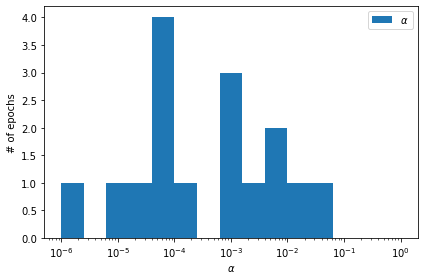

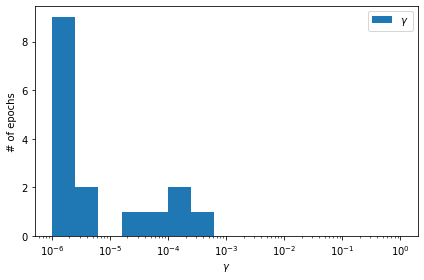

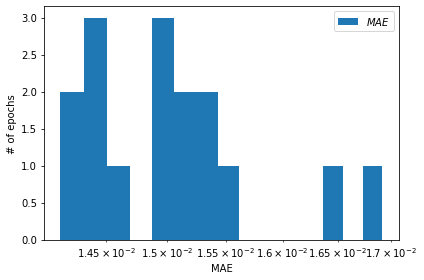

In [11]:
fig, ax = plt.subplots()
ax.hist(results['alphas'],bins=np.logspace(start=-6, stop=0, num=16), label=r'$\alpha$')
ax.set_xscale('log')
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel('# of epochs')
ax.legend()
fig.tight_layout()
fig, ax = plt.subplots()
ax.hist(results['gammas'],bins=np.logspace(start=-6, stop=0, num=16), label=r'$\gamma$')
ax.set_xscale('log')
ax.set_xlabel(r'$\gamma$')
ax.set_ylabel('# of epochs')
ax.legend()
fig.tight_layout()
fig, ax = plt.subplots()
ax.hist(results['mae'],bins=np.linspace(start=np.amin(results['mae']), stop=np.amax(results['mae']), num=16), label=r'$MAE$')
ax.set_xscale('log')
ax.set_xlabel(r'MAE')
ax.set_ylabel('# of epochs')
ax.legend()
fig.tight_layout()

In [12]:
print("Variation of alpha: {:.2e}.\t Variation of gamma: {:.2e}.".format(np.amax(results['alphas']) - np.amin(results['alphas']), np.amax(results['gammas']) - np.amin(results['gammas'])))

Variation of alpha: 2.51e-02.	 Variation of gamma: 2.50e-04.


### Question:
- Do the optimized model parameters change with different subsets?
- How large of a variation do you observe in the training data?
- Can we use the same set of parameters for all subsets of 100 entries?

### Answers:
- Results show that optimized model parameters change with different subsets.
- The variations of $\alpha$ and $\gamma$ are 1.58e-01 and 6.30e-04 respectively.
- The optimized parameters for one subset are not representative. In that case, one may not use the same set of parameters for all subsets. Additionally, ensemble modeling shows that it is always useful to train several models indepdently from different initializations or with different hyper-parameters, and then average the outputs. However, some technics might be helpful for accelerating the training process for all subsets, that is transfer learning. Even thought transfer learning is widely used to deal with data-limitation problem, it should also be transferable on dealing with different subsets.

## Problem 2: Plot a learning curve

Fit the Coulomb Matrix model using 4 randomly-selected training sets of 10, 100, and 1000 entries.

- Plot how the model accuracy on a test set, training time and inference times change as a function of training set size.

In [13]:
sizes = [10, 100, 1000]
results_LearnCur = []
for size in tqdm(sizes):
    train_data_epoch = train_data.sample(size)
    gs.set_params(n_jobs=2)
    
    train_time = perf_counter()
    gs.fit(np.vstack(train_data_epoch['cm']), train_data_epoch['homo'])
    train_time = perf_counter() - train_time
    
    test_time = perf_counter()
    y_pred = gs.predict(np.vstack(test_data['cm']))
    test_time = perf_counter() - test_time
    
    results_LearnCur.append({
        "MAE": mean_absolute_error(y_pred, test_data['homo']),
        "train_time": train_time,
        "test_time": test_time,
    })
    
results_LearnCur = pd.DataFrame(results_LearnCur)

 67%|██████▋   | 2/3 [00:07<00:04,  4.03s/it]/Users/jiaweizhan/anaconda3/envs/applied-ai/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
100%|██████████| 3/3 [00:54<00:00, 18.22s/it]


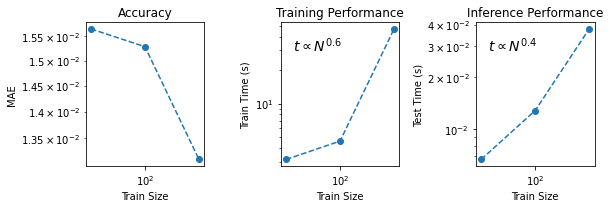

In [14]:
fig, axs = plt.subplots(1, 3, figsize=(8.5, 3.))

ax = axs[0]
ax.loglog(sizes, results_LearnCur['MAE'], '--o')
ax.set_ylabel('MAE')
ax.set_title('Accuracy')

ax = axs[1]
ax.loglog(sizes, results_LearnCur['train_time'], '--o')
p = linregress(np.log(sizes[-3:]), np.log(results_LearnCur['train_time'].iloc[-3:]))
ax.text(0.1, 0.8, f'$t \propto N^{{{p[0]:.1f}}}$', transform=ax.transAxes, fontsize=14)
ax.set_ylabel('Train Time (s)')
ax.set_title('Training Performance')

ax = axs[2]
ax.loglog(sizes, results_LearnCur['test_time'], '--o')
p = linregress(np.log(sizes[-3:]), np.log(results_LearnCur['test_time'].iloc[-3:]))
ax.text(0.1, 0.8, f'$t \propto N^{{{p[0]:.1f}}}$', transform=ax.transAxes, fontsize=14)
ax.set_ylabel('Test Time (s)')
ax.set_title('Inference Performance')

for ax in axs:
    ax.set_xlabel('Train Size')

fig.tight_layout()

## Problem 3: Optimize the training set.

We are going to use a genetic algorithm to determine an optimized training set with $100$ entries.

First, separate off a "validation set" of 1000 entries from the training set that we will use to assess the performance of our specially-chosen training sets.

Now, implement a function that will accept a list of points from the training set by their index and produce the score of that model on the validation set. This function will be used by the genetic algorithm to score each selection of points. It should fulfill the following signature:

In [15]:
def evaluate_subset(points: list, model, train_data: pd.DataFrame, test_data: pd.DataFrame) -> float:
    """Test a subset of points
    
    Args:
        points: Which points from the train_data to sample
        model: Model to use for testing
        train_data: All available training points
        test_data: Data used to test the model
    Returns:
        MAE on the test set
    """
    model.set_params(n_jobs=6)
    model.fit(np.vstack(train_data['cm'].iloc[points]), train_data['homo'].iloc[points])
    predict = model.predict(np.vstack(test_data['cm']))
    return mean_absolute_error(predict, test_data['homo'])

In [16]:
train_data, valid_data = train_test_split(train_data, test_size=1000)

Next, run the genetic algorithm code provided at the end of this document (also includes an explaination of GAs)

In [17]:
from random import sample

def mutate(points: set, total: int, fraction: float = 0.1) -> set:
    """Mutate a set of points
    
    Mutates from selecting points randomly from the dataset
    
    Args:
        points: Set of points to be mutated
        total: Total number of samples to choose from in dataset
        fraction: How many points to re-select
    """
    
    # Remove the desired amount of points
    n_to_remove = int(len(points) * fraction)
    to_remove = sample(points, k=n_to_remove)
    new_points = points.difference(to_remove)
    
    # Add more points to the set
    available_choices = set(range(total)).difference(new_points)
    new_points.update(sample(available_choices, n_to_remove))
    
    return new_points

def crossover(parent_a: set, parent_b: set):
    """Perform a crossover operation
    
    Randomly chooses points from both parents
    
    Args:
        parent_a: One choice of points
        parent_b: Another choice of points
    Returns:
        A new set that combines both parents
    """
    
    # Combine all points from each parents
    options = parent_a.union(parent_b)
    
    # Pick randomly from the combined set
    return set(sample(options, len(parent_a)))

In [18]:
# Defining options
n_generations = 50
pop_size = 8
dataset_size = 100

# Array in which to store all results
all_options = []

# Make an initial population
#  Creates sets where each have different entries pull from the full dataset
population = np.array([set(sample(range(len(train_data)), k=100)) for i in range(pop_size)])

# Loop over the generations
for gen in tqdm(range(n_generations), desc='generation'):
    # Score each member of the population
    scores = [
        evaluate_subset(list(s), gs, train_data, valid_data) for s 
        in population
    ]
    
    # Store the results in the history
    for i, s in enumerate(population):
        all_options.append({
            'generation': gen,
            'points': s,
            'score': scores[i]
        })
        
    # Sort scores and pick the best quarter
    ranks = np.argsort(scores)
    best_members = population[ranks[:pop_size // 4]]
    
    # Create new members by crossover and mutation
    new_population = []
    for i in range(pop_size):
        # Pick two parents at random
        parent_a, parent_b = sample(best_members.tolist(), 2)
        
        # Form a new member by crossover
        new_member = crossover(parent_a, parent_b)
        
        # Mutate it for good measure
        new_population.append(
            mutate(new_member, total=len(train_data))
        )
    
    # Replace population with new population
    population = np.array(new_population)

all_options = pd.DataFrame(all_options)

generation: 100%|██████████| 50/50 [16:59<00:00, 20.40s/it]


- Plot the best score in the population change as a function of generation. Hint: Convert the all_options to a DataFrame and use Panda's [aggregation functions].

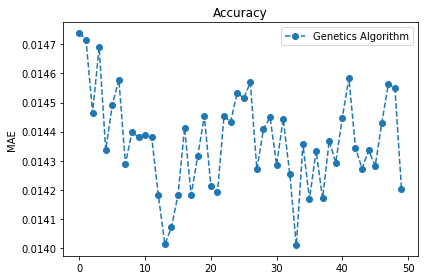

In [19]:
fig, ax = plt.subplots()

ax.plot(list(range(n_generations)), all_options.groupby('generation').aggregate(np.min)['score']
        , '--o', label='Genetics Algorithm')
ax.set_ylabel('MAE')
ax.set_title('Accuracy')
# ax.set_yscale('log')
ax.legend()

fig.tight_layout()

- Plot the performance of your optimized model with the learning curve from problem 2. How does it compare?

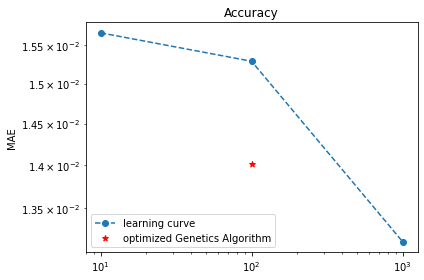

In [20]:
fig, ax = plt.subplots()

ax.loglog(sizes, results_LearnCur['MAE'], '--o', label='learning curve')
ax.scatter(100, np.amin(all_options.groupby('generation').aggregate(np.min)['score']), marker='*', color='r', label='optimized Genetics Algorithm')
ax.set_ylabel('MAE')
ax.set_title('Accuracy')
ax.legend()

fig.tight_layout()

The result above shows that Genetics Algorithm increases the model's accuracy by iteratively mutating populations as well as generating offsprings based on desired parents.